 <font size="+2"><p style="text-align: center;"><b> Auswertung Versuch 213 PAP 2.1. </p></font>

In [1]:
%matplotlib inline
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.odr import Data, RealData, Model, ODR

In [2]:
plt.rc('lines', linewidth = 0.4, marker = '.', markersize = 3, markeredgewidth = 0.4)
plt.rc('errorbar', capsize = 2, )

In [3]:
g = 9.81

# 2) Dämpfung

In [4]:
t = np.array([0, 120, 240, 360, 480, 600, 720])
Dt = 1
f = np.array([705, 645.1, 592.4, 544.3, 501.3, 462.2, 427.0])/60
Df = 2.0/60.0
om = 2*pi*f
Dom = 2*pi*Df

Was muss überhaupt gefittet werden?  Geg: x-Input: Zeiten, y-Input: Frequenzen. Man sieht, dass die Frequenz über die Zeit abnimmt -> Dämpfung. Ges: Amplitude A und Dämpfungskonstante Delta. Wie sieht also die zugehörige Funktion aus? Die folgende Funktion om_fit gibt in Abhängigkeit der Zeit t und den Parametern A und Delta eine Frequenz zurück.

In [5]:
def om_fit(t, A, delta):
    return A*np.exp(-delta*t)

Da zwei Parameter, A und Delta, gesucht sind, ist die Kovarianzmatrix eine 2x2-Matrix. 

In [6]:
popt, pcov = curve_fit(om_fit, t, om, sigma = np.repeat(Dom, om.size), p0 = [70,0.0005])
A = popt[0]
delta = popt[1]
DA = np.sqrt(pcov[0][0])
Ddelta = np.sqrt(pcov[1][1])

print("Amplitude: ", A, " +- ", DA)
print("Dämpfung: ", delta, " +- ", Ddelta)

('Amplitude: ', 73.57117335155341, ' +- ', 0.15403606657415073)
('D\xc3\xa4mpfung: ', 0.0006995108402443952, ' +- ', 5.744159790395555e-06)


In [7]:
chi2_ = np.sum((om_fit(t, *popt) - om)**2/Dom**2)
dof = om.size - 2
chi2_red = chi2_/dof
print("chi2 = ", chi2_)
print("chi2_red = ", chi2_red)

('chi2 = ', 4.894350881470707)
('chi2_red = ', 0.9788701762941414)


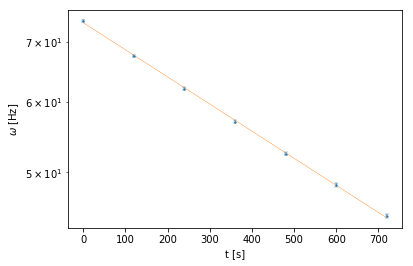

In [8]:
plt.errorbar(t, om, xerr = Dt, yerr = Dom, linestyle = 'none')
plt.plot(t, om_fit(t, A, delta), marker = '')
plt.yscale('log')
plt.xlabel('t [s]')
plt.ylabel(r'$\omega$ [Hz]')
plt.savefig('figures/daempfung.pdf')

In [9]:
# Halbwertzeit
T_halb = - np.log(1.0/2.0)/delta
DT_halb = T_halb*(Ddelta/delta)
print(T_halb, " +- ", DT_halb)

(990.9027004038614, ' +- ', 8.13697675630816)


# 3) Präzession

In [10]:
f_f = np.empty((4, 4))
T_p = np.empty((4, 4))

# 1 Gewicht bei 20cm
f_f[0] = np.array([675.4, 540.1, 388.2, 249.3])/60
T_p[0] = np.array([86.43, 69.2, 50.75, 33.01])

# 1 Gewicht bei 15cm
f_f[1] = np.array([680.1, 531.2, 376.5, 254.3])/60
T_p[1] = np.array([112.21, 88.4, 63.1, 42.12])

# 2 Gewichte bei 15cm
f_f[2] = np.array([692.6, 554.6, 385.2, 255.4])/60
T_p[2] = np.array([61.07, 47.96, 33.61, 21.70])

#2 Gewichte bei 20cm
f_f[3] = np.array([721.1, 541.9, 401.1, 234.5])/60
T_p[3] = np.array([50.46, 38.31, 28.95, 17.15])

DT_p = 1.0

om_f_start = 2*pi*f_f; om_f_start

array([[70.72772261, 56.55913974, 40.65220894, 26.10663495],
       [71.21990546, 55.62713392, 39.4269878 , 26.63023373],
       [72.5289024 , 58.07757619, 40.33804967, 26.74542546],
       [75.51341542, 56.7476353 , 42.00309378, 24.55678258]])

In [11]:
om_f_end = om_fit(T_p, om_f_start, delta)
om_f = (om_f_start + om_f_end)/2; om_f

array([[68.65301768, 55.22283816, 39.94328655, 25.80867602],
       [68.53168709, 53.9593303 , 38.57577534, 26.24364819],
       [71.01234043, 57.11952767, 39.86939537, 26.54396876],
       [74.20395118, 55.99736423, 41.58207225, 24.41036351]])

In [12]:
Dom_f_end = 1.0/2*np.sqrt(((1 + np.exp(-delta*T_p))*Dom)**2 + (om_f*T_p*np.exp(-delta*T_p)*Ddelta)**2 + (om_f*delta*np.exp(-delta*T_p)*DT_p)**2)
Dom_f = 1.0/2*np.sqrt(Dom**2 + Dom_f_end**2)
Dom_f

array([[0.1465967 , 0.14673915, 0.14699203, 0.14732428],
       [0.1461069 , 0.14630408, 0.14668641, 0.14710068],
       [0.14715925, 0.14724611, 0.14740771, 0.14761247],
       [0.14744247, 0.14745944, 0.14753767, 0.14771668]])

In [13]:
m = np.array([1, 1, 2, 2])*9.85e-3
l = np.array([20e-2, 15e-2, 15e-2, 20e-2])

In [14]:
def T_p_fit(om_f, I_z, m, l):
    return 2*pi*I_z*om_f/(m*g*l)

In [15]:
I_z_fit = np.empty(4)
DI_z_fit = np.empty(4)

for i in range(4):
    param = T_p[i, 0]*m[i]*g*l[i]/(2*pi*om_f[i, 0])
    popt, pcov = curve_fit(lambda om_f, I_z: T_p_fit(om_f, I_z, m[i], l[i]), om_f[i], T_p[i], sigma = np.repeat(DT_p, T_p[i].size))
    I_z_fit[i] = popt[0]
    DI_z_fit[i] = np.sqrt(pcov[0][0])

print(I_z_fit)
print(DI_z_fit)

[0.00387655 0.0037719  0.00391404 0.00421367]
[1.33655180e-05 1.10963344e-05 3.31966581e-05 2.49304456e-05]


In [16]:
I_z_odr = np.empty(4)
DI_z_odr = np.empty(4)

for i in range(4):
    
    def T_p_odr(I_z, om_f, m = m[i], l = l[i]):
        return 2*pi*I_z*om_f/(m*g*l)

    model = Model(T_p_odr)
    data = RealData(x = om_f[i], y = T_p[i], sx = Dom_f[i], sy = np.repeat(DT_p, T_p[i].size))

    odr = ODR(data, model, beta0 = [1])
    output = odr.run()
    eta_odr = output.beta[0]
    Deta_odr = output.sd_beta[0]
    
    I_z_odr[i] = eta_odr
    DI_z_odr[i] = Deta_odr

print(I_z_odr)
print(DI_z_odr)

[0.00387656 0.00377191 0.00391405 0.00421367]
[1.33646100e-05 1.10934345e-05 3.31962883e-05 2.49302759e-05]


In [17]:
I_z = np.average(I_z_odr)
DI_z = np.std(I_z_odr)/2
print("I_z = " , I_z, " +- ", DI_z)

('I_z = ', 0.003944046312813618, ' +- ', 8.207583675870874e-05)


In [18]:
I_z = np.average(I_z_fit)
DI_z = np.std(I_z_fit)/2
print("I_z = " , I_z, " +- ", DI_z)

('I_z = ', 0.0039440388519379034, ' +- ', 8.20765858146825e-05)


In [19]:
Dl = 2e-3
DT_p_fit = np.empty((4, 4))
for i in range(4):
    DT_p_fit[i] = T_p_fit(om_f[i], I_z, m[i], l[i])*np.sqrt((DI_z/I_z)**2 + (Dl/l[i])**2)
print(DT_p_fit)

[[2.03252922 1.63491768 1.18255395 0.76408714]
 [2.89588828 2.28011594 1.63006546 1.1089567 ]
 [1.50035563 1.20682693 0.84236446 0.56082355]
 [1.09843459 0.82892408 0.61553578 0.36134447]]


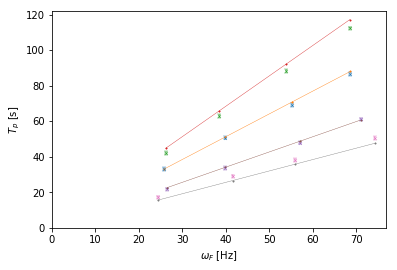

In [20]:
for i in range(4):
    plt.errorbar(om_f[i], T_p[i], xerr = np.repeat(Dom, om_f[i].size), yerr = np.repeat(DT_p, T_p[i].size), marker = 'x', linestyle = 'none')
    plt.plot(om_f[i], T_p_fit(om_f[i], I_z, m[i], l[i]))
plt.xlim(left = 0)
plt.ylim(bottom = 0)
plt.xlabel(r'$\omega_F$ [Hz]')
plt.ylabel('$T_p$ [s]')
plt.savefig('figures/praezession.pdf')

In [21]:
for i in range(4):
    chi2_ = np.sum((T_p_fit(om_f[i], I_z, m[i], l[i]) - T_p[i])**2/DT_p**2)
    dof = T_p.size - 1
    chi2_red = chi2_/dof
    print("Messreihe ", i, ": ", "chi2 = ", chi2_)
    print("chi2_red = ", chi2_red)

('Messreihe ', 0, ': ', 'chi2 = ', 5.3937839119876)
('chi2_red = ', 0.3595855941325067)
('Messreihe ', 1, ': ', 'chi2 = ', 55.16537352372141)
('chi2_red = ', 3.6776915682480937)
('Messreihe ', 2, ': ', 'chi2 = ', 2.0944922711894494)
('chi2_red = ', 0.13963281807929662)
('Messreihe ', 3, ': ', 'chi2 = ', 21.6091188086864)
('chi2_red = ', 1.4406079205790934)


# 4) Nutation 1

In [22]:
t = np.array([17.20, 18.37, 20.74, 21.32, 22.75, 25.54, 27.04, 29.89, 32.86, 36.73])
f = np.array([603.0, 560.4, 525.1, 487.3, 455.8, 421.2, 384.1, 351.3, 322.4, 285.7])/60
om_f = 2*pi*f
Om = 2*pi*10/t
DOm = Om*(Dt/t)
Om

array([3.65301471, 3.42035128, 3.02950111, 2.94708504, 2.7618397 ,
       2.4601352 , 2.32366321, 2.10210281, 1.91210752, 1.71064125])

In [23]:
def Om_fit(om_f, I_x):
    return (I_x - I_z)/I_x*om_f

In [24]:
param = [0.005]
popt, pcov = curve_fit(Om_fit, om_f, Om, sigma = DOm)
I_x = popt[0]
DI_x = np.sqrt(pcov[0][0])
print("I_x = ", I_x, " +- ", DI_x)

('I_x = ', 0.004182585349115063, ' +- ', 1.2324355015742064e-06)


In [25]:
def Om_odr(I_x, om_f1):
    return (I_x - I_z)/I_x*om_f1

In [26]:
chi2_ = np.sum((Om_fit(om_f, I_x) - Om)**2/DOm**2)
dof = Om.size - 1
chi2_red = chi2_/dof
print("chi2 = ", chi2_)
print("chi2_red = ", chi2_red)

('chi2 = ', 1.4396854778475048)
('chi2_red = ', 0.1599650530941672)


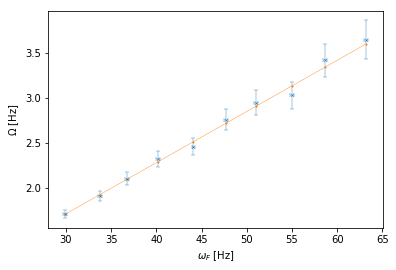

In [27]:
plt.errorbar(om_f, Om, xerr = Dom, yerr = DOm, marker = 'x', linestyle = 'none')
plt.plot(om_f, Om_fit(om_f, I_x))
plt.xlabel(r'$\omega_F$ [Hz]')
plt.ylabel(r'$\Omega$ [Hz]')
plt.savefig('figures/nutation_Omega.pdf')

# 5) Nutation 2

In [28]:
om_f = np.array([733.5, 884.2, 435.5, 372.2, 345.1, 305.6, 650.2, 540.3, 505.8, 450.9])/60
om_n = np.array([700, 870, 400, 350, 320, 285, 610, 505, 475, 425])/60
Dom_n = 0.5

In [29]:
def om_n_fit(om_f, I_x):
    return I_z/I_x*om_f

In [30]:
param = [I_x]
popt, pcov = curve_fit(om_n_fit, om_f, om_n, sigma = np.repeat(Dom_n, om_n.size))
I_x_ = popt[0]
DI_x_ = np.sqrt(pcov[0][0])
print(I_x_, " +- ", DI_x_)

(0.0043942934569893705, ' +- ', 7.961885772436099e-05)


In [31]:
chi2_ = np.sum((om_n_fit(om_f, I_x_) - om_n)**2/Dom_n**2)
dof = om_n.size - 1
chi2_red = chi2_/dof
print("chi2 = ", chi2_)
print("chi2_red = ", chi2_red)

('chi2 = ', 8.024576318506378)
('chi2_red = ', 0.8916195909451532)


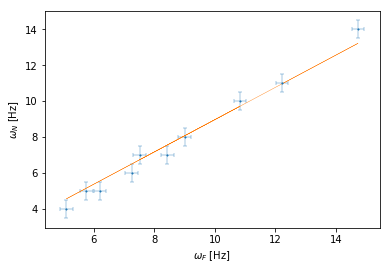

In [32]:
plt.errorbar(om_f, om_n, xerr = Dom, yerr = Dom_n, linestyle = 'none')
plt.plot(om_f, om_n_fit(om_f, I_x_), marker = '')
plt.xlabel(r'$\omega_F$ [Hz]')
plt.ylabel(r'$\omega_N$ [Hz]')
plt.savefig('figures/nutation_om_n.pdf')